<a href="https://colab.research.google.com/github/gz54054/Homework/blob/main/Homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [ ]:
from thinkdsp import decorate

### Exercise 1

A sawtooth signal has a waveform that ramps up linearly from -1 to 1, then drops to -1 and repeats. See http://en.wikipedia.org/wiki/Sawtooth_wave

Write a class called `SawtoothSignal` that extends `Signal` and provides `evaluate` to evaluate a sawtooth signal.

Compute the spectrum of a sawtooth wave. How does the harmonic structure compare to triangle and square waves? 

### Solution

My solution is basically a simplified version of TriangleSignal.

In [ ]:
from thinkdsp import Sinusoid
from thinkdsp import normalize, unbias
import numpy as np

class SawtoothSignal(Sinusoid):
    """Represents a sawtooth signal."""
    
    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        cycles = self.freq * ts + self.offset / np.pi / 2
        frac, _ = np.modf(cycles)
        ys = normalize(unbias(frac), self.amp)
        return ys

聽起來像:

In [ ]:
sawtooth = SawtoothSignal().make_wave(duration=0.5, framerate=40000)
sawtooth.make_audio()

spectrum看起來像是:

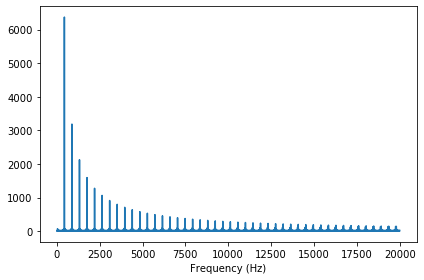

In [ ]:
sawtooth.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

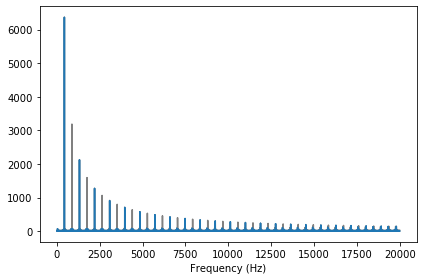

In [ ]:
from thinkdsp import SquareSignal

sawtooth.make_spectrum().plot(color = 'gray')
square = SquareSignal(amp = 0.5).make_wave(duration = 0.5, framerate = 40000)
square.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

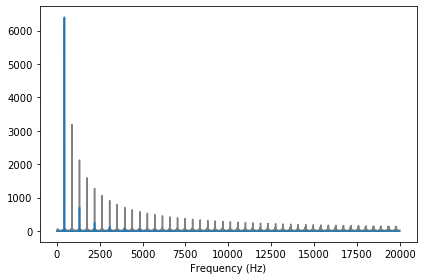

In [ ]:
from thinkdsp import TriangleSignal

sawtooth.make_spectrum().plot(color='gray')
triangle = TriangleSignal(amp=0.79).make_wave(duration=0.5, framerate=40000)
triangle.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

具體來說，三角波的諧波按 1 / f2 的比例下降，而鋸齒波按 1 / f 的比例下降。

### Exercise 2

Make a square signal at 1500 Hz and make a wave that samples it
at 10000 frames per second.  If you plot the spectrum, you can
see that most of the harmonics are aliased.
When you listen to the wave, can you hear the aliased harmonics? 

### Solution

這裡有個方波:

In [ ]:
square = SquareSignal(1500).make_wave(duration=0.5, framerate=10000)

spectrum:

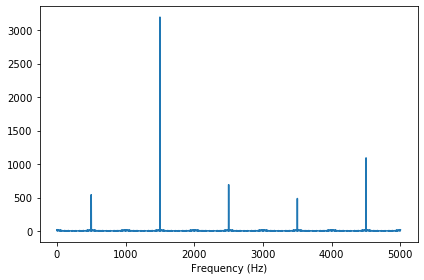

In [ ]:
square.make_spectrum().plot()
decorate(xlabel='Frequency (Hz)')

可以看到1500Hz的基波和4500 Hz的一次諧波，但是應該在 7500 Hz 的二次諧波被混疊到 2500 Hz。

應該在 10500 Hz 的三次諧波會混疊到 -500 Hz，但會再次混疊到 500 Hz。

第4次諧波本應為 13500 Hz，但以 3500 Hz 結束。

第5次諧波本應為 16500 Hz，但以 1500 Hz 結束，因此它對基波有貢獻。

其餘的諧波與我們已經看到的諧波重疊。

In [ ]:
square.make_audio()

因此，聽起來跟下面的正弦波會有差別。

In [ ]:
from thinkdsp import SinSignal

SinSignal(500).make_wave(duration=0.5, framerate=10000).make_audio()

### Exercise 3

If you have a spectrum object, `spectrum`, and print the first few values of `spectrum.fs`, you’ll see that the frequencies start at zero. So `spectrum.hs[0]` is the magnitude of the component with frequency 0. But what does that mean?

Try this experiment:

1.    Make a triangle signal with frequency 440 and make a Wave with duration 0.01 seconds. Plot the waveform.
2.    Make a Spectrum object and print `spectrum.hs[0]`. What is the amplitude and phase of this component?
3.    Set `spectrum.hs[0] = 100`. Make a Wave from the modified Spectrum and plot it. What effect does this operation have on the waveform?

### Solution

這裡有個三角波:

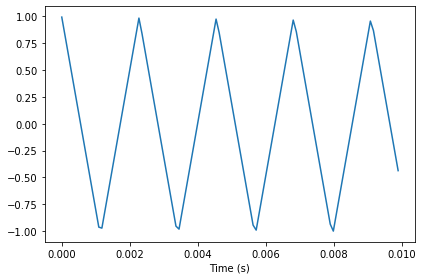

In [ ]:
triangle = TriangleSignal().make_wave(duration=0.01)
triangle.plot()
decorate(xlabel='Time (s)')

頻譜的第一個元素是一個接近於零的複數如下:

In [ ]:
spectrum = triangle.make_spectrum()
spectrum.hs[0]

(1.0436096431476471e-14+0j)

將這個spectrum設成100後與原圖比較，可以看到頻譜垂直偏移的效果:

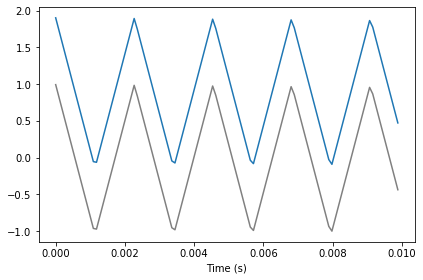

In [ ]:
spectrum.hs[0] = 100
triangle.plot(color='gray')
spectrum.make_wave().plot()
decorate(xlabel='Time (s)')

零頻率分量是信號中所有值的總和，當我們進入 DFT 的細節時會看到。如果信號是離散的，則零頻率分量為 0。在上下文中在電信號中，零頻率項稱為 DC 偏移；即添加到 AC 信號的直流偏移。

### Exercise 4

Write a function that takes a Spectrum as a parameter and modifies it by dividing each element of hs by the corresponding frequency from fs. Test your function using one of the WAV files in the repository or any Wave object.

1. Compute the Spectrum and plot it.
2. Modify the Spectrum using your function and plot it again.
3. Make a Wave from the modified Spectrum and listen to it. What effect does this operation have on the signal?

### Solution

In [ ]:
def filter_spectrum(spectrum):
    """Divides the spectrum through by the fs.
    
    spectrum: Spectrum object
    """
    # avoid division by 0
    spectrum.hs[1:] /= spectrum.fs[1:]
    spectrum.hs[0] = 0

這裡有個三角波:

In [ ]:
wave = TriangleSignal(freq=440).make_wave(duration=0.5)
wave.make_audio()

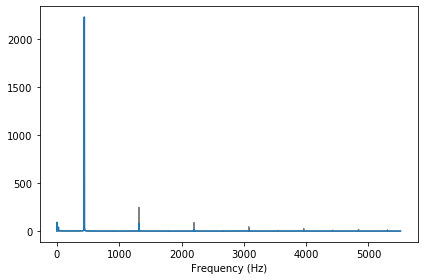

In [ ]:
spectrum = wave.make_spectrum()
spectrum.plot(high=10000, color='gray')
filter_spectrum(spectrum)
spectrum.scale(440)
spectrum.plot(high=10000)
decorate(xlabel='Frequency (Hz)')

In [ ]:
filtered = spectrum.make_wave()
filtered.make_audio()

三角波現在聽起來幾乎像正弦波。

### Exercise 5

The triangle and square waves have odd harmonics only; the sawtooth wave has both even and odd harmonics. The harmonics of the square and sawtooth waves drop off in proportion to $1/f$; the harmonics of the triangle wave drop off like $1/f^2$. Can you find a waveform that has even and odd harmonics that drop off like $1/f^2$?

Hint: There are two ways you could approach this: you could
construct the signal you want by adding up sinusoids, or you
could start with a signal that is similar to what you want and
modify it.

### Solution
從鋸齒波開始，它具有我們需要的所有諧波：

In [ ]:
freq = 500
signal = SawtoothSignal(freq=freq)
wave = signal.make_wave(duration=0.5, framerate=20000)
wave.make_audio()

這是頻譜的樣子。諧波下降幅度為1/f。

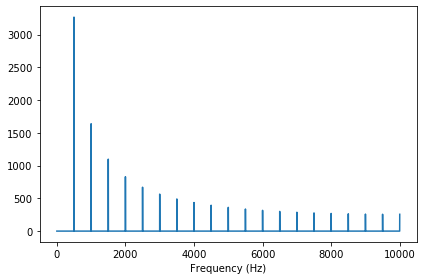

In [ ]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

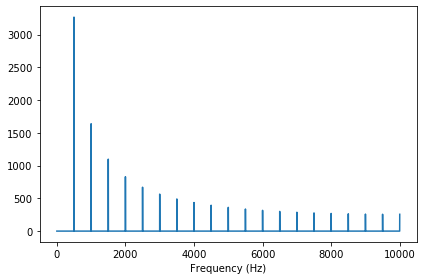

In [ ]:
spectrum = wave.make_spectrum()
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

應用上一個練習中編寫的濾波器，使諧波下降幅度變為$1/f^2$。

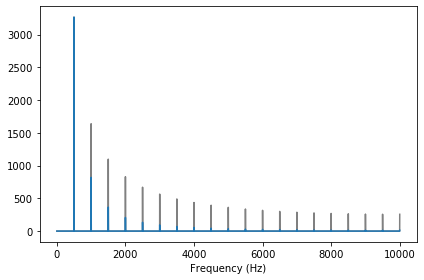

In [ ]:
spectrum.plot(color='gray')
filter_spectrum(spectrum)
spectrum.scale(freq)
spectrum.plot()
decorate(xlabel='Frequency (Hz)')

聲音聽起來:

In [ ]:
wave = spectrum.make_wave()
wave.make_audio()

波型看起來:

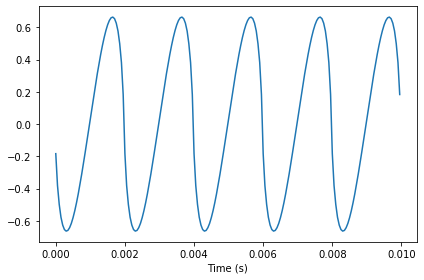

In [ ]:
wave.segment(duration=0.01).plot()
decorate(xlabel='Time (s)')